In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import datetime as dt
import seaborn as sns
from sklearn import decomposition
from sklearn import preprocessing


#On importe le jeu de données nettoyées

#La base de données est trop grande pour être chargée en une fois, on va la charger par morceaux
mylist = []

for chunk in pd.read_csv('database_clean.csv', chunksize=20000, low_memory=False):
    mylist.append(chunk)

data = pd.concat(mylist, axis= 0)
del mylist


data.head()

,product_name,labels_tags,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,energy-kcal_100g,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,Caramels tendres au beurre salé au sel de Guér...,en:produced-in-brittany,28.0,e,Sugary snacks,Sweets,NaN,10.9,7.0,49.3,NaN,3.0,1.7000,0.0
1,Jacquet Les bouchées créatives à garnir,en:no-palm-oil,10.0,c,Salty snacks,Appetizers,NaN,15.5,1.3,2.0,3.0,8.5,1.7526,0.0
2,Lulu la barquette fraise,"en:made-in-france,en:sans-colorants",13.0,d,Sugary snacks,Biscuits and cakes,351.0,2.0,0.6,58.0,1.7,3.8,0.0900,27.8
3,Cookies tout chocolat Biocoop,"en:organic,en:eu-organic,en:fair-trade,en:made...",19.0,e,Sugary snacks,Biscuits and cakes,NaN,25.0,14.0,33.0,5.5,7.0,0.3810,0.0
4,Milka Ganze Nuss,"en:cocoa-life,en:made-in-germany,en:pure-cocoa...",25.0,e,Sugary snacks,Chocolate products,555.0,36.0,15.0,47.0,2.0,8.4,0.3000,20.0


In [2]:
print(data.shape)
print(data.columns)

(483000, 14)
Index(['product_name', 'labels_tags', 'nutriscore_score', 'nutriscore_grade',
       'pnns_groups_1', 'pnns_groups_2', 'energy-kcal_100g', 'fat_100g',
       'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g'],
      dtype='object')


In [3]:
#Commençons par lister les données quantitatives, en les séparant selon leurs échelles
quanti_100 = ['fat_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
quanti_autres = ['nutriscore_score', 'energy-kcal_100g']
    
# Propriétés graphiques (pour rendre les boxplots plus lisibles)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

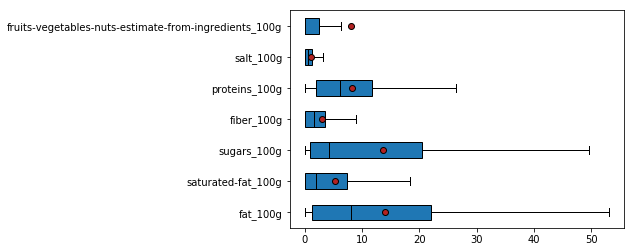

In [4]:
#On va afficher les différentes données quantitatives, sur des boxplots différents selon les échelles
donnees = []
for m in quanti_100:
    donnees.append(data.dropna(axis='index', subset=[m])[m])

#D'abord on affiche les données qui s'échelonnent entre 0 et 100
plt.boxplot(donnees, labels=quanti_100, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

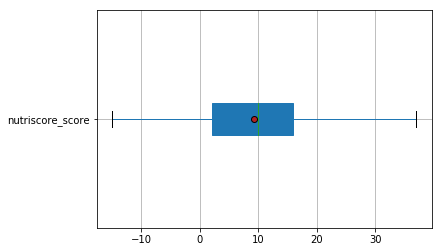

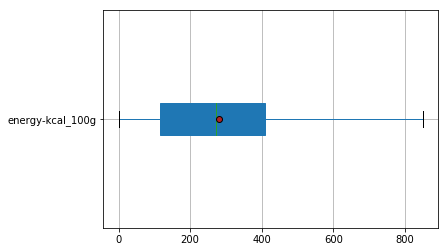

In [5]:
#On affichera les autres boxplots sur des graphes différents car ils n'auront pas les mêmes échelles
for c in quanti_autres :
    data.boxplot(column=c, labels=[c], showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

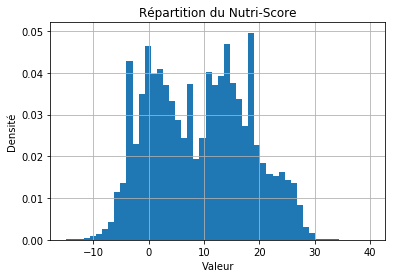

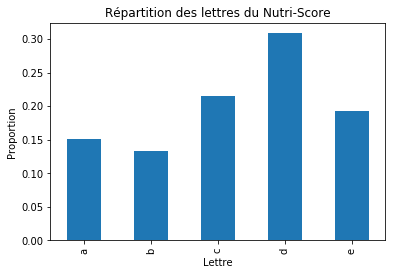

In [6]:
#On va visualiser la distribution du nutriscore via un histogramme
data['nutriscore_score'].hist(density=True, bins = 50)
plt.title('Répartition du Nutri-Score')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

# Voyons également la répartition des lettres du nutriscore au sein de notre échantillon
X = data['nutriscore_grade'].value_counts(normalize=True)
X.sort_index(inplace=True)
X.plot(kind='bar',width=0.5)
plt.title('Répartition des lettres du Nutri-Score')
plt.xlabel('Lettre')
plt.ylabel('Proportion')
plt.show()

In [7]:
#On va vérifier si les différentes catégories de produits contiennent toutes les catégories de Nutriscore,
#pour voir si notre application sera pertinente ou non
X = "nutriscore_grade"
Y = "pnns_groups_1"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
print(cont)

pnns_groups_1     Alcoholic beverages  Beverages  Cereals and potatoes  \
nutriscore_grade                                                         
a                                 1.0     2780.0               20818.0   
b                                 NaN     6429.0                9687.0   
c                                10.0     6584.0               10986.0   
d                                18.0     5390.0                8433.0   
e                                10.0    10758.0                1549.0   
Total                            39.0    31941.0               51473.0   

pnns_groups_1     Composite foods  Fat and sauces  Fish Meat Eggs  \
nutriscore_grade                                                    
a                          5331.0          1712.0          7347.0   
b                          9962.0          2771.0          7275.0   
c                         11968.0         11505.0          9973.0   
d                          9080.0         11666.0         1658

In [8]:
#On peut afficher ce tableau de manière plus lisible
#On définit les constantes pour renormaliser et obtenir des proportions
tot = cont.loc[["Total"],:]

#On renormalise
for m in cont.columns:
    cont[m] = cont[m].div(tot[m]['Total'], fill_value=0)

#Retirons les totaux de "cont" pour plus de clarté
cont.drop(columns=['Total'], inplace=True)
cont.drop(index=['Total'], inplace=True)

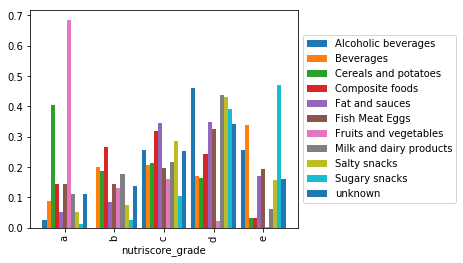

In [9]:
#Affichons la répartition des lettres du nutriscore en fonction des groupes
fig = plt.figure()
ax = plt.subplot(111)
cont.plot(ax=ax, kind='bar' ,width=0.9)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [10]:
#Les proportions de 'a' et de 'b' semblent faibles pour les 'alcoholic beverages' et les 'sugary snacks',
#pour le deuxième les produits ayant une note 'a' ou 'b' sont présentes, justes faibles en proportion

#La boisson alcoolisée "a" devrait être une erreur, car pour les boissons seules les eaux peuvent être notées "a"
data[data["pnns_groups_1"]=="Alcoholic beverages"][["product_name", "nutriscore_grade", "pnns_groups_1"]]

,product_name,nutriscore_grade,pnns_groups_1
2945,Maracuja-Saft,e,Alcoholic beverages
11494,Mon thé pour le bureau,c,Alcoholic beverages
41074,Sangria,e,Alcoholic beverages
143512,Eau Cristaline,a,Alcoholic beverages
148058,Ochakovo - Kvass 2L,d,Alcoholic beverages
150793,Kombucha Dtox,d,Alcoholic beverages
158802,"Premium Pils, 0,5 L, 4.8 % Vol.",e,Alcoholic beverages
159158,Jhonnie walker red label blended,e,Alcoholic beverages
199926,Bière sans alcool pur malt,d,Alcoholic beverages
206964,Berliner luft,e,Alcoholic beverages


In [11]:
#Le "a" vient d'une "eau cristalline" qui est mal référencée. Il n'y a pas de "b" dans notre base de données

In [12]:
#On peut désormais jeter un oeil aux liens entre les différentes variables quantitatives, notamment leurs correlations entre elles
quanti = quanti_autres + quanti_100
correl = data[quanti].corr()
print(correl)

                                                    nutriscore_score  \
nutriscore_score                                            1.000000   
energy-kcal_100g                                            0.576266   
fat_100g                                                    0.494573   
saturated-fat_100g                                          0.589133   
sugars_100g                                                 0.454307   
fiber_100g                                                 -0.152771   
proteins_100g                                               0.067829   
salt_100g                                                   0.129222   
fruits-vegetables-nuts-estimate-from-ingredient...         -0.230789   

                                                    energy-kcal_100g  \
nutriscore_score                                            0.576266   
energy-kcal_100g                                            1.000000   
fat_100g                                                    0.7

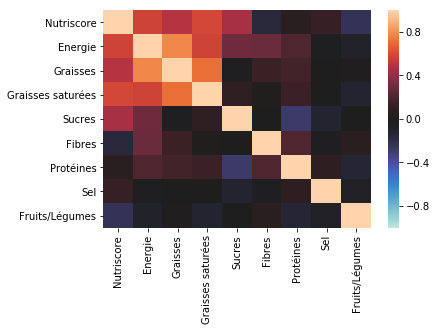

In [13]:
#On va lister les noms des variables de manière plus lisible
noms = ['Nutriscore', 'Energie', 'Graisses', 'Graisses saturées', 'Sucres', 'Fibres', 'Protéines', 'Sel', 'Fruits/Légumes']

#On peut rendre cela plus visuel grâce à une heatmap
sns.heatmap(correl, center=0, vmin=-1, vmax=1, xticklabels=noms, yticklabels=noms)

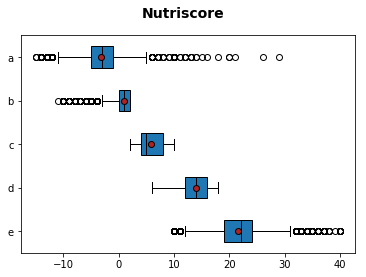

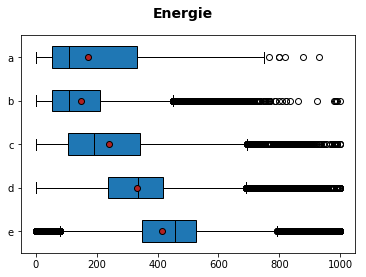

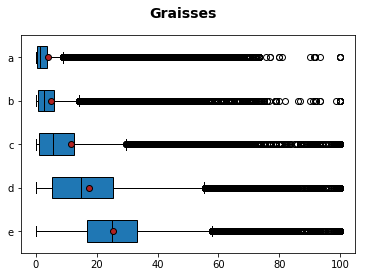

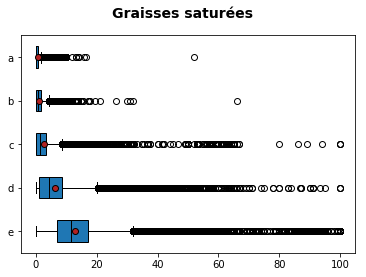

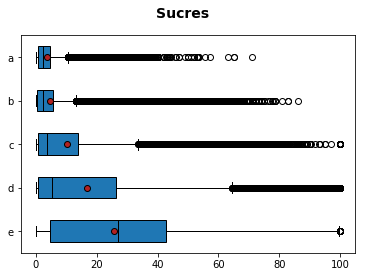

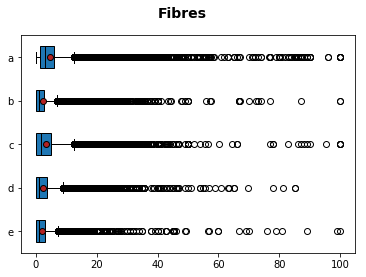

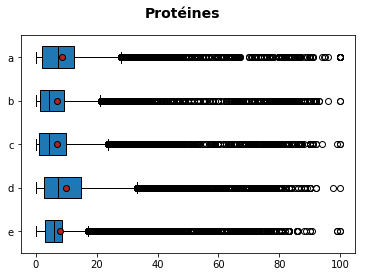

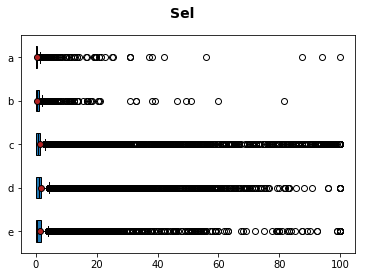

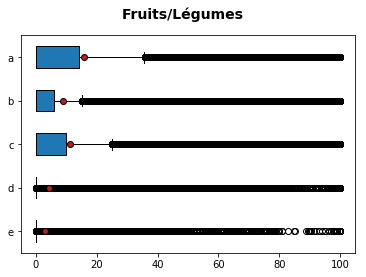

In [14]:
#L'impact des différentes variables sur le calcul du Nutriscore commence à apparaître, on le mettra plus en lumière avec une ACP

#On va tâcher de voir la répartition des différentes données quantitatives selon la lettre du nutriscore
lettres = ['e','d','c','b','a']

for i in range(len(quanti)):
    donnees = []
    for l in lettres:
        donnees.append(data[data['nutriscore_grade']==l][quanti[i]].dropna().tolist())
   
    fig = plt.figure()
    fig.suptitle(noms[i], fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)
    ax.boxplot(donnees, labels=lettres, showfliers=True, medianprops=medianprops, 
                vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show() 

In [15]:
#On va tâcher de retrouver l'influence de ces variables sur le nutriscore à l'aide d'une ACP

#Les fonctions suivantes sont directement issues du cours d'Open Classroom "Réalisez une analyse exploratoire de données"
#et nous permettront de mieux visualiser les résultats de l'ACP

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, importantes_var=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        if labels[i] in importantes_var:
                            plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="red", alpha=0.5)
                        else:
                            plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [16]:
print(quanti)

['nutriscore_score', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


In [17]:
#Nous avons 9 variables quantitatives, nous pouvons donc avoir jusqu'à 9 axes pertinents pour l'ACP
n_comp = 9

#On restreint notre database aux colonnes quantitatives
data_pca = data[quanti]

#On prépare les données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data['product_name'] #pour avoir les noms des produits
features = data_pca.columns

In [18]:
#Centrage et Réduction de nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

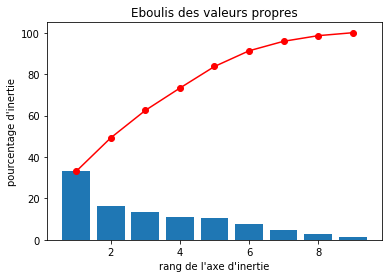

In [19]:
#Eboulis des valeurs propres
display_scree_plot(pca)

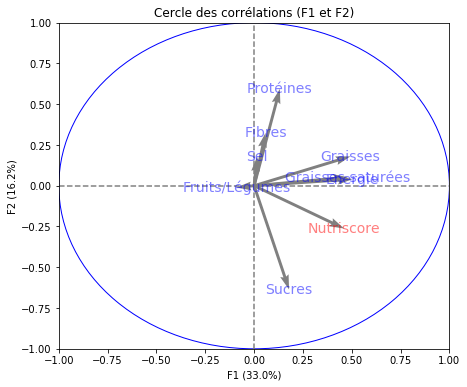

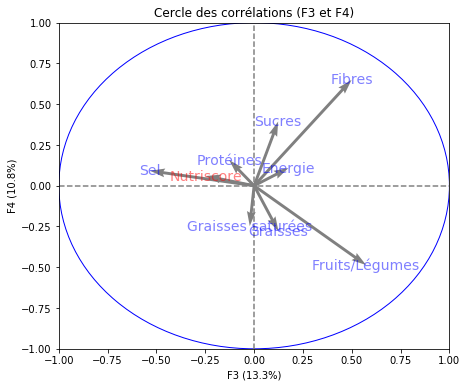

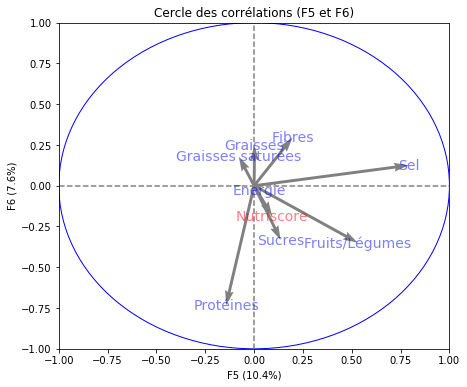

In [20]:
#Cercle des corrélations pour les 6 premières variables principales (critère de Kaiser)
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = noms, importantes_var=['Nutriscore'])

In [21]:
#On va désormais chercher si le label "Bio" a un effet sur le nutriscore

#On va définir une fonction pour chercher le mot-clé "organic" dans les labels
def detect_words(values):
    result = []
    for lib in values:
        produit_type = "NON-BIO"
        if lib == lib: #pour éviter les nan
            if ("organic" in lib) or ("natural" in lib):
                produit_type = "BIO"
        result.append(produit_type)
    return result

#Puis on va créer une colonne "type" pour tous les produits indiquant s'ils sont Bio ou non
data["type"] = detect_words(data["labels_tags"])

NON-BIO    428134
BIO         54866
Name: type, dtype: int64
NON-BIO    88.64058
BIO        11.35942
Name: type, dtype: float64


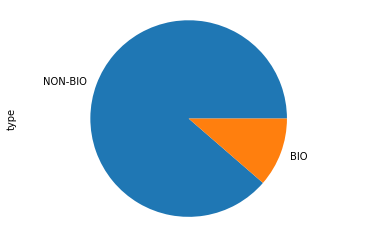

In [22]:
#On va afficher la proportion de produits Bio dans notre base de données
print(data["type"].value_counts())
print(data["type"].value_counts(normalize=True)*100)
data["type"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

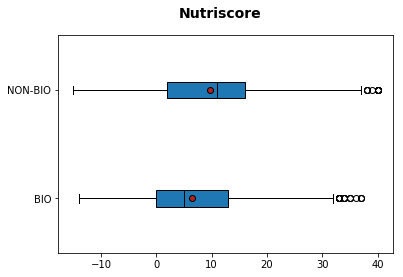

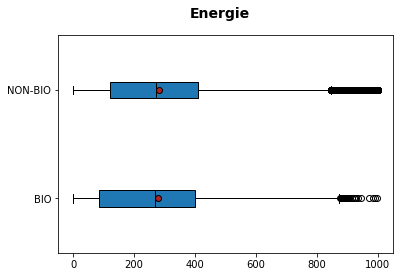

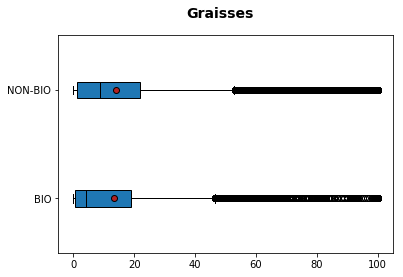

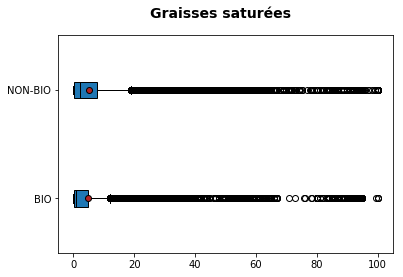

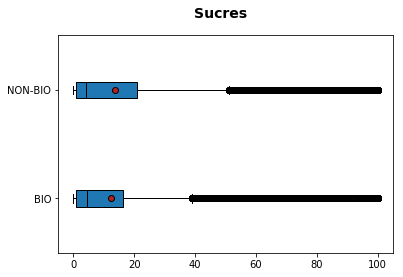

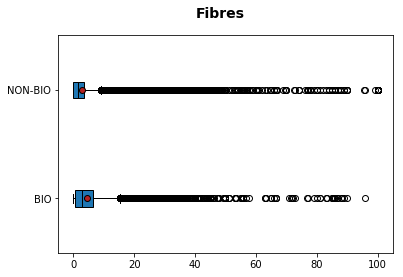

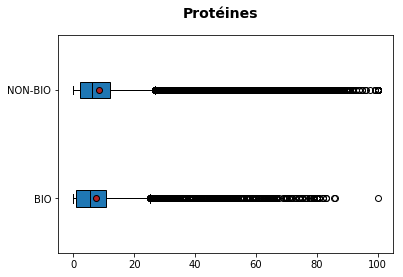

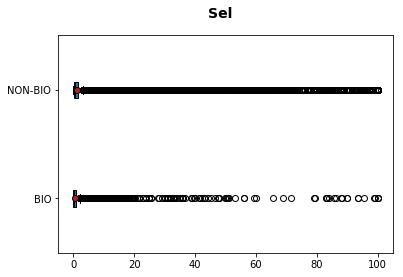

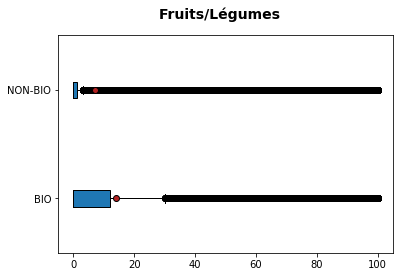

In [23]:
#On va voir la répartition des différentes données quantitatives selon le caractère Bio du produit
types = ['BIO', 'NON-BIO']
for i in range(len(quanti)):
    donnees = []
    donnees.append(data[data['type']=='BIO'][quanti[i]].dropna().tolist())
    donnees.append(data[data['type']=='NON-BIO'][quanti[i]].dropna().tolist())
   
    fig = plt.figure()
    fig.suptitle(noms[i], fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)
    ax.boxplot(donnees, labels=types, showfliers=True, medianprops=medianprops, 
                vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show() 

In [24]:
#On va faire une ANOVA entre le label Bio et le Nutriscore, grâce à cette fonction adaptée du cours d'Open Classroom
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(data['type'], data['nutriscore_score'])

0.013613735124738048

In [25]:
#Le coefficient est TRES petit, donc il semblerait que le label Bio n'ait que très peu d'influence sur le Nutriscore